In [1]:
from datasets import load_dataset

dataset = load_dataset("banking77")

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /root/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [66]:
# X_train = pd.DataFrame(dataset["train"]["text"], columns=["text"])
y_train = pd.DataFrame(dataset["train"]["label"], columns=["label"])

# X_test = pd.DataFrame(dataset["test"]["text"], columns=["text"])
y_test = pd.DataFrame(dataset["test"]["label"], columns=["label"])

In [4]:
%%capture
!pip install nltk
!pip install contractions
!pip install Unidecode
!pip install textblob
!pip install pyspellchecker

In [10]:
import contractions
import re
import nltk
import spacy
from nltk.tokenize import word_tokenize
from string import punctuation
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from unidecode import unidecode


class EnglishPipeline():
    
    def __init__(self,
                 cased=False,
                 lemmatized=True,
                 stemmed=False,
                 remove_stopwords=False,
                 remove_contractions=True,
                 remove_numbers=True,
                 remove_punctuation=True,
                 fix_spelling=False
                ):
    
        self.cased = cased
        self.lemmatized = lemmatized
        self.stemmed = stemmed
        self.remove_stopwords = remove_stopwords
        self.remove_contractions = remove_contractions
        self.remove_numbers = remove_numbers
        self.remove_punctuation = remove_punctuation
        self.fix_spelling = fix_spelling

        if self.remove_stopwords:
            nltk.download("stopwords")
            self.stopwords = stopwords.words('english')
        if self.stemmed:
            if self.lemmatized:
                self.lemmatized = False
            self.stemmer = SnowballStemmer("english")
        if self.lemmatized:
            self.nlp = spacy.load("en_core_web_sm")
    
    def transform(self, string):
        
        if self.cased:
            string = string.lower()
            
        # remove diacritics
        string = unidecode(string, errors="preserve")
            
        if self.remove_contractions:
            string = " ".join([contractions.fix(expanded) for expanded in string.split()])
            
        if self.remove_numbers:
            string = re.sub(r'\d+', '', string)
            
        if self.fix_spelling:
            string = str(TextBlob(string).correct())
            
        if self.remove_punctuation:
            string = " ".join(x for x in word_tokenize(string) if x not in punctuation)
            
        if self.lemmatized:
            string = " ".join(x.lemma_ for x in self.nlp(string))
        elif self.stemmed:
            string = self.stemmer.stem(string) 
            
        if self.remove_stopwords:
            string = " ".join([word for word in string.split() if word not in self.stopwords])
            
        # remove trailing spaces
        string = re.sub(' +', ' ', string)
        
        return string

In [12]:
pipeline = EnglishPipeline()

In [67]:
from tqdm.auto import tqdm
tqdm.pandas()

with open("intent_mapper.txt", "r") as f:
    intent_mapper = {int(x.split()[0]): x.split()[1] for x in f.readlines()}

# X_train["lemmas"] = X_train["text"].progress_apply(lambda x: pipeline.transform(x))
# X_test["lemmas"] = X_test["text"].progress_apply(lambda x: pipeline.transform(x))
y_train["label"] = y_train["label"].map(intent_mapper)
y_test["label"] = y_test["label"].map(intent_mapper)

Text(0.5, 1.0, 'Train Labels distribution')

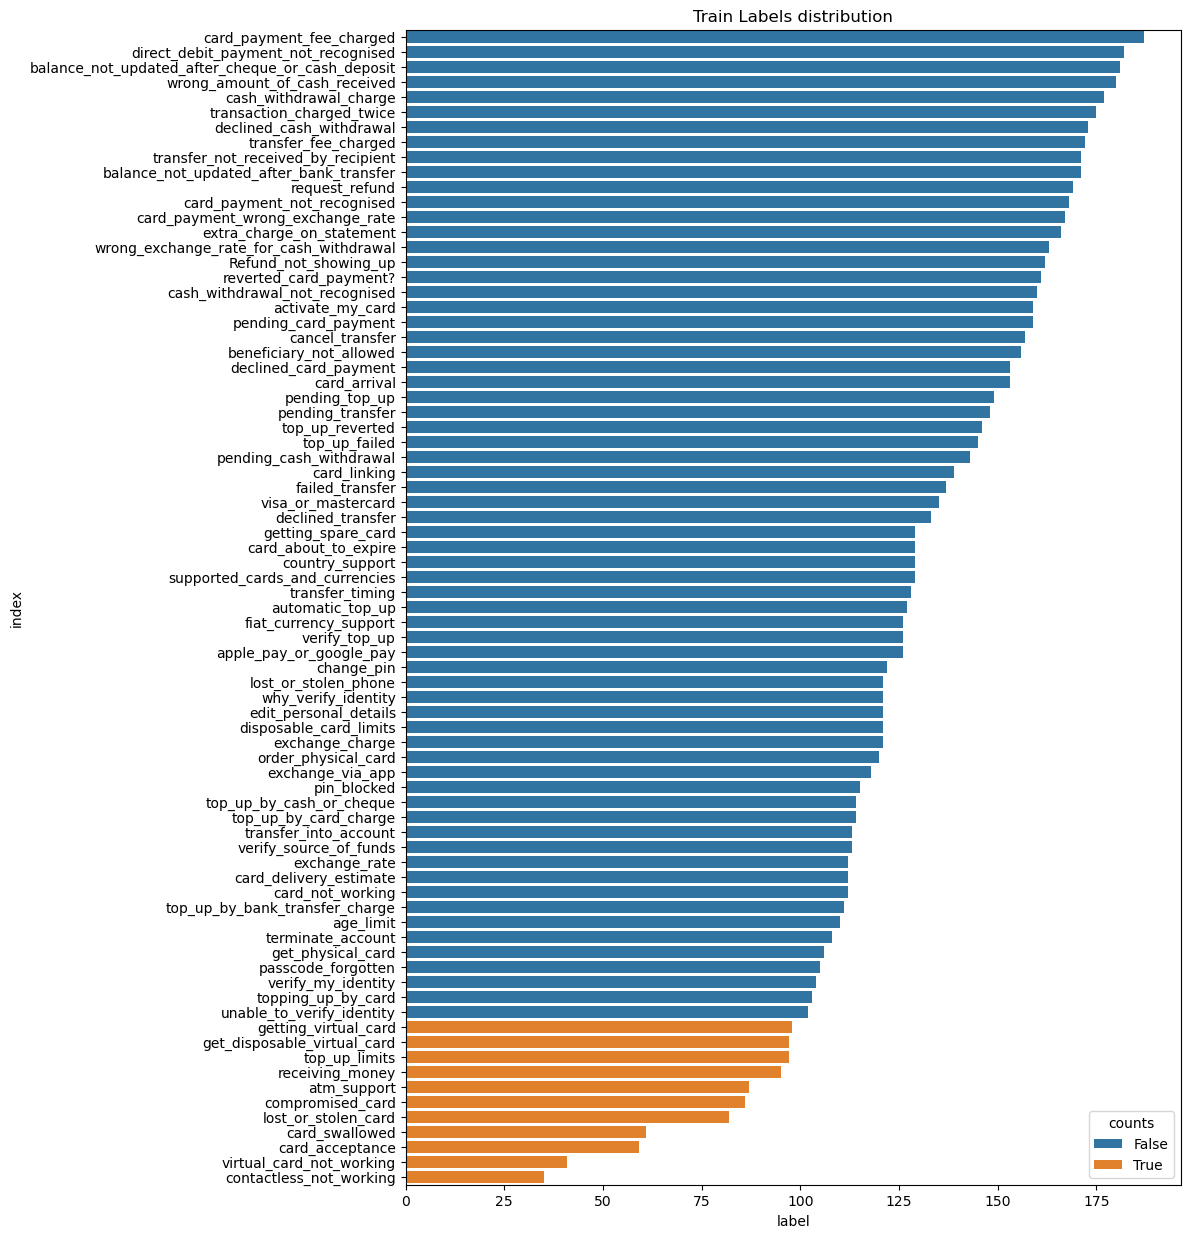

In [112]:
sub_df = y_train['label'].value_counts().reset_index()
sub_df["counts"] = sub_df.label < 100


plt.figure(figsize=(10, 15))

sns.barplot(y="index", x="label", hue="counts", data=sub_df, dodge=False)

plt.title("Train Labels distribution")

# y_train.value_counts().plot.bar()

То, что оранжевым - явно несбалансированно. Можно доаугментить данных, можно не трогать, можно взять планку повыше и доаугментить более частые категории. В целом всё довольно балансно

Text(0.5, 1.0, 'Test Labels distribution')

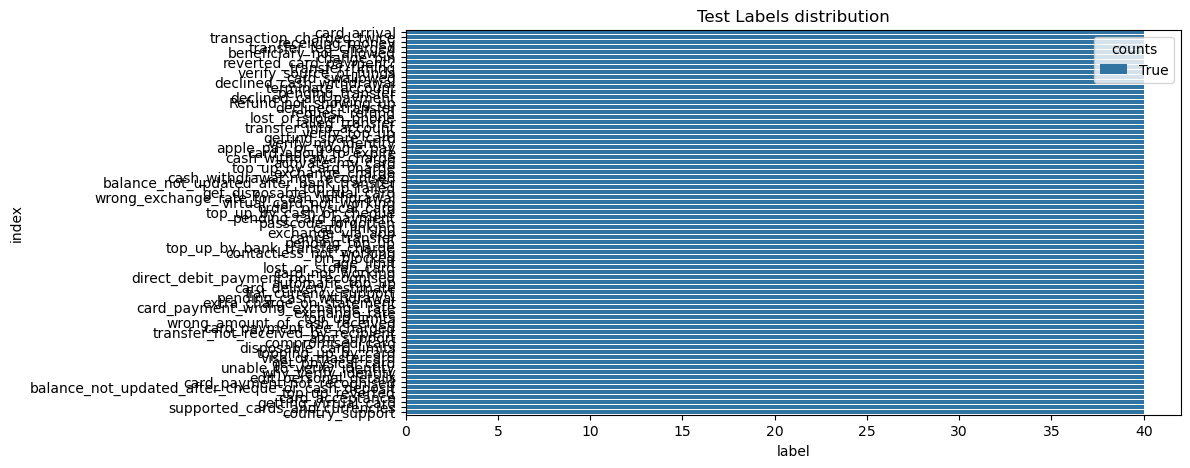

In [111]:
sub_df = y_test['label'].value_counts().reset_index()
sub_df["counts"] = sub_df.label < 100


plt.figure(figsize=(10, 5))

sns.barplot(y="index", x="label", hue="counts", data=sub_df, dodge=False)

plt.title("Test Labels distribution")

# y_train.value_counts().plot.bar()

На тесте всё ровно, это и хорошо - можно проверить все лейблы, и плохо - в жизни распределение не такое

In [114]:
X_train["sent_len"] = X_train.text.apply(lambda x: len(x.split()))
X_test["sent_len"] = X_test.text.apply(lambda x: len(x.split()))

Text(0.5, 0.98, 'Sentence length distribution')

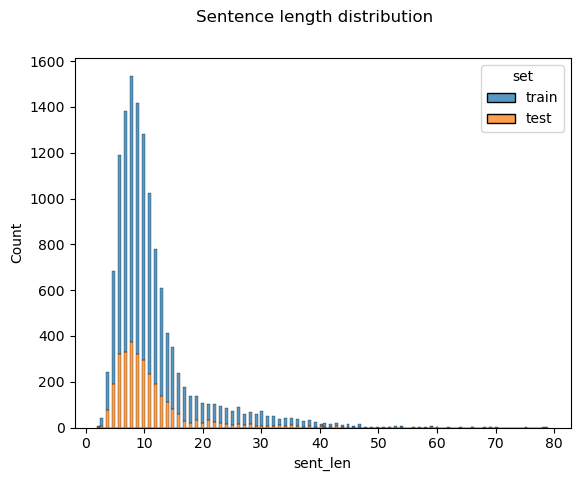

In [137]:
X_train["set"] = "train"
X_test["set"] = "test"

sub_df = pd.concat([X_train, X_test])

sns.histplot(x="sent_len", data=sub_df, hue="set", multiple="stack")

plt.suptitle("Sentence length distribution")

В среднем очень короткие тексты - по 10 слов, максимум 40-52

In [157]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
cv_data = vectorizer.fit_transform(X_train.text)

Уникальных слов вообще очень мало - 2320, видимо, не стоит выкидывать стопслова, и так очень мало

In [151]:
cv_data

<10003x2320 sparse matrix of type '<class 'numpy.int64'>'
	with 102326 stored elements in Compressed Sparse Row format>

(-0.5, 1599.5, 799.5, -0.5)

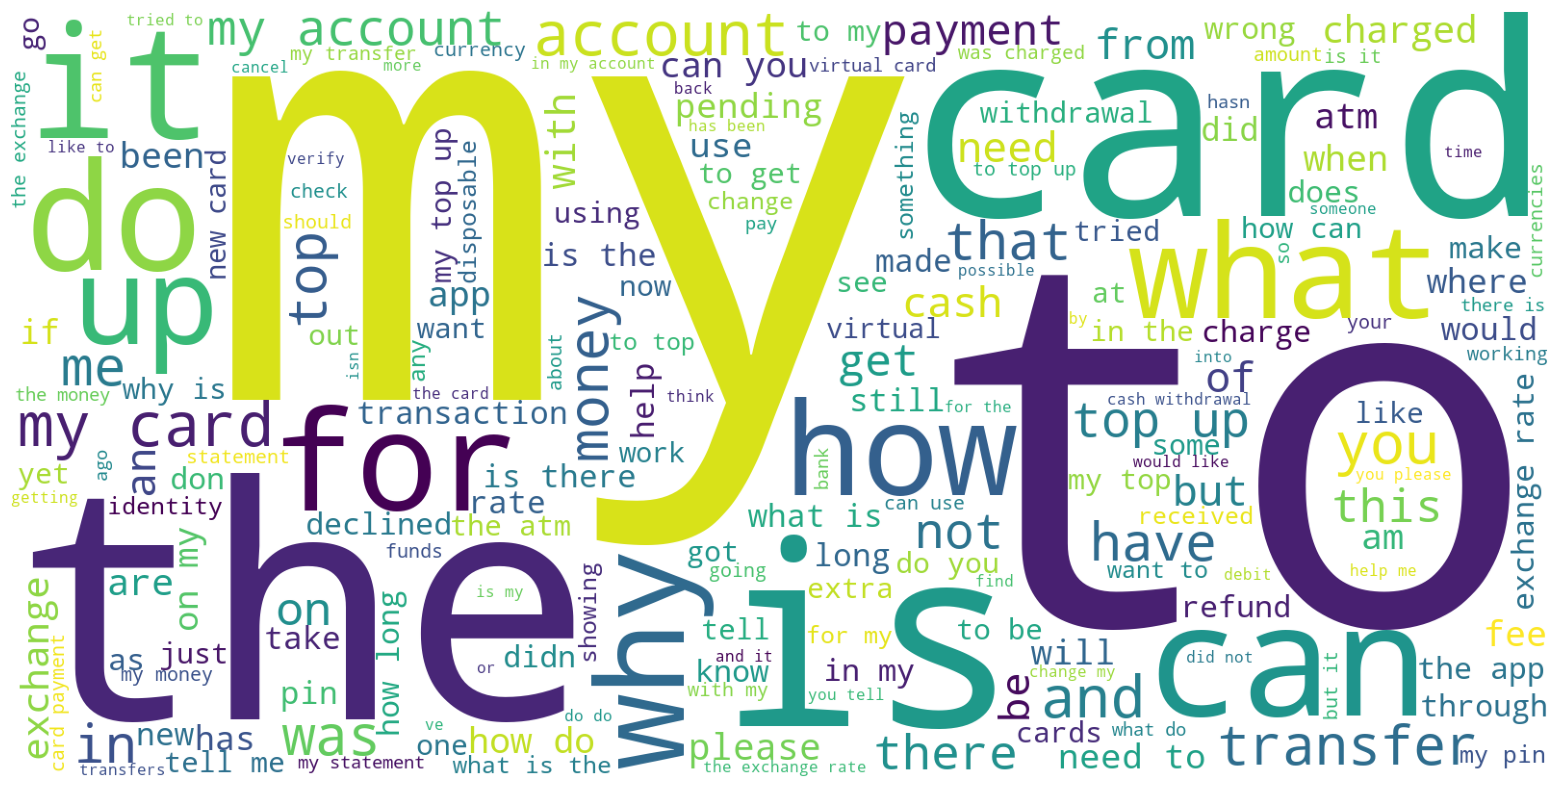

In [170]:
from wordcloud import WordCloud

sum_words = cv_data.sum(axis=0)
    
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

wordcloud = WordCloud(background_color="white",
                      width=1600, height=800).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")

Большинство нграмм так или иначе связано с банками, что логично, но это подсказывает нам, где брать ood-примеры - явно не с этими словами

In [176]:
blob = TextBlob(str(X_train.text))
pos_df = pd.DataFrame(blob.tags, columns=['word', 'pos'])
#top_pos = pd.DataFrame(pos_df['pos'].value_counts(), columns=['pos', 'count'])
top_pos = pos_df['pos'].value_counts()

In [204]:
from collections import Counter
from nltk import pos_tag

def get_pos(df):
    
    pos = []
    
    for i in tqdm(range(df.shape[0])):
        
        poss = Counter()
        blob = pos_tag(df.iloc[i].text.split(), tagset='universal')

        for word, tag in blob:
            if tag in poss:
                poss[tag] += 1
            else:
                poss.update({tag: 0})
        
        pos.append(poss)
        
    return pd.DataFrame(pos).fillna(0.0)

In [207]:
train_pos = get_pos(X_train)
test_pos = get_pos(X_test)

  0%|          | 0/10003 [00:00<?, ?it/s]

  0%|          | 0/3080 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Parts of speech distribution')

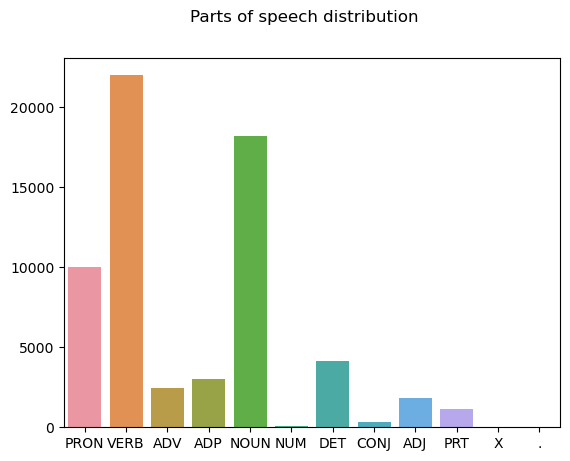

In [215]:
sub_df = train_pos.sum()
sns.barplot(x=sub_df.index, y=sub_df.values)
plt.suptitle("Parts of speech distribution")

Это не очень интересная информация, но это +фичи, вряд ли сильно помогут, но потенциал есть

Дальше я пока пытаюсь найти какую-нибудь закономерность в данных, чтобы их покластеризовать, пока безрезультатно

In [240]:
def make_svd_right(svd, n):
    
    u, s, vt = svd

    u[:,:n] = u[:, n-1::-1]
    s = s[::-1]
    vt[:n, :] = vt[n-1::-1, :]

    vt = vt.T
    
    return u, s, vt

In [222]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 5))
tfidf_data = tfidf_vectorizer.fit_transform(X_train.text)


Можно посмотреть на распределение запросов в пространстве, но кластеров слишком много, вряд ли сможем увидеть их все

In [223]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
proj = tsne.fit_transform(tfidf_data)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


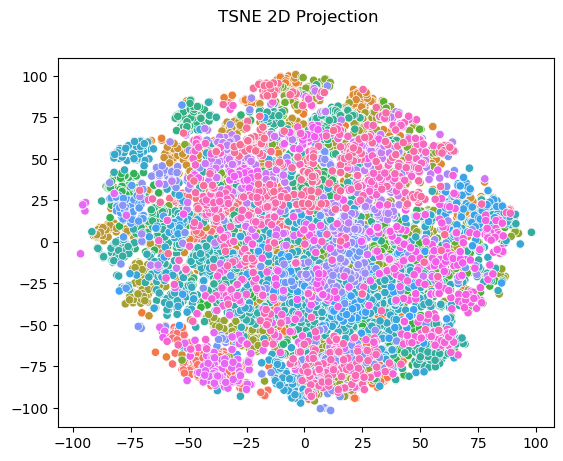

In [253]:
sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=y_train["label"])
plt.suptitle("TSNE 2D Projection")
plt.legend([],[], frameon=False)

Слишком плотно, по крайней мере по tfidf ood не задетектить, можно попробовать PCA и LSA

In [246]:
import scipy

u, s, vt = make_svd_right(scipy.sparse.linalg.svds(tfidf_data, 100), 100)

Сингулярные значения довольно маленькие по модулю и не то чтобы быстро убывают, чтобы сделать нормальный LSA придётся взять большую размерность => PCA не сработает

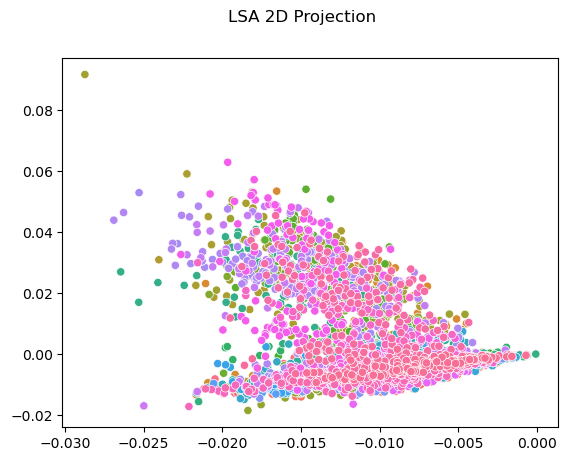

In [254]:
sns.scatterplot(x=u[:, 0], y=u[:, 1], hue=y_train["label"])
plt.suptitle("LSA 2D Projection")
plt.legend([],[], frameon=False)